# Getting started with `pyrenew`

This notebook illustrates two features of `pyrenew`: (a) the set of included `RandomVariable`es, and (b) model composition.

## Hospitalizations model

`pyrenew` has five main components:

- Utility and math functions,
- The `processes` sub-module,
- The `observations` sub-module,
- The `latent` sub-module, and
- The `models` sub-module

All three of `process`, `observation`, and `latent` contain classes that inherit from the meta class `RandomVariable`. The classes under `model` inherit from the meta class `Model`. The following diagram illustrates the composition the model `pyrenew.models.HospitalizationsModel`:

```{mermaid}
flowchart TB

    subgraph randprocmod["Processes module"]
        direction TB
        simprw["SimpleRandomWalkProcess"]
        rtrw["RtRandomWalkProcess"]        
    end

    subgraph latentmod["Latent module"]
        direction TB
        hosp_latent["Hospitalizations"]
        inf_latent["Infections"]
    end

    subgraph obsmod["Observations module"]
        direction TB
        pois["PoissonObservation"]
        nb["NegativeBinomialObservation"]
    end

    subgraph models["Models module"]
        direction TB
        basic["RtInfectionsRenewalModel"]
        hosp["HospitalizationsModel"]
    end

    rp(("RandomVariable")) --> |Inherited by| randprocmod
    rp -->|Inherited by| latentmod
    rp -->|Inherited by| obsmod


    model(("Model")) -->|Inherited by| models

    simprw -->|Composes| rtrw
    rtrw -->|Composes| basic
    inf_latent -->|Composes| basic
    basic -->|Composes| hosp


    obsmod -->|Composes|models
    hosp_latent -->|Composes| hosp

    %% Metaclasses
    classDef Metaclass color:black,fill:white
    class rp,model Metaclass

    %% Random process
    classDef Randproc fill:purple,color:white
    class rtrw,simprw Randproc

    %% Models
    classDef Models fill:teal,color:white
    class basic,hosp Models
```

We start by loading the needed components to build a basic renewal model:

In [7]:
import jax.numpy as jnp
import numpy as np
import numpyro as npro
from pyrenew.process import RtRandomWalkProcess
from pyrenew.latent import Infections
from pyrenew.observation import PoissonObservation
from pyrenew.model import RtInfectionsRenewalModel

In the basic renewal model we can define three components: Rt, latent infections, and observed infections.

In [8]:
latent_infections = Infections(
    gen_int=jnp.array([0.25, 0.25, 0.25, 0.25]),
    )

observed_infections = PoissonObservation(
    rate_varname='latent',
    counts_varname='observed_infections',
    )

rt_proc = RtRandomWalkProcess()

With observation process for the latent infections, we can build the basic renewal model, and generate a sample calling the `sample()` method:

In [9]:

model1 = RtInfectionsRenewalModel(
    Rt_process=rt_proc,
    latent_infections=latent_infections,
    observed_infections=observed_infections,
    )

np.random.seed(223)
with npro.handlers.seed(rng_seed=np.random.randint(1, 60)):
    sim_data = model1.sample(constants=dict(n_timepoints=30))

sim_data

InfectModelSample(Rt=Array([1.2022278, 1.2111099, 1.2325984, 1.2104921, 1.2023039, 1.1970979,
       1.2384264, 1.2423582, 1.245498 , 1.241344 , 1.2081108, 1.1938375,
       1.271196 , 1.3189521, 1.3054799, 1.3165426, 1.291952 , 1.3026639,
       1.2619467, 1.2852622, 1.3121517, 1.2888998, 1.2641873, 1.2580931,
       1.2545817, 1.3092988, 1.2488269, 1.2397509, 1.2071848, 1.2334517,
       1.21868  ], dtype=float32), latent=Array([ 3.7023427,  4.850682 ,  6.4314823,  8.26245  ,  6.9874763,
        7.940377 ,  9.171101 , 10.051114 , 10.633459 , 11.729475 ,
       12.559867 , 13.422887 , 15.364211 , 17.50132  , 19.206314 ,
       21.556652 , 23.78112  , 26.719398 , 28.792412 , 32.40454  ,
       36.641006 , 40.135487 , 43.60607  , 48.055103 , 52.829704 ,
       60.43277  , 63.97854  , 69.82776  , 74.564415 , 82.88904  ,
       88.73811  ], dtype=float32), observed=Array([ 4,  3,  6,  5,  7,  7, 10, 11,  6,  9,  7, 13, 16, 19, 20, 27, 23,
       31, 28, 30, 43, 42, 55, 57, 44, 52, 64, 52,

The `sample()` method of the `RtInfectionsRenewalModel` returns a list composed of the `Rt` and `infections` sequences.

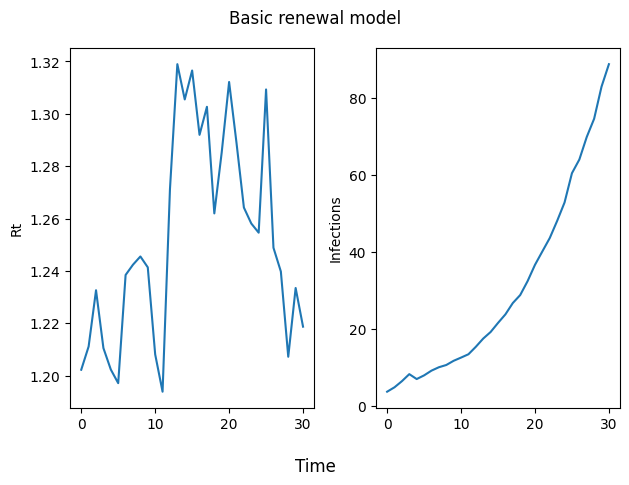

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

# Rt plot
axs[0].plot(range(0, 31), sim_data[0])
axs[0].set_ylabel('Rt')

# Infections plot
axs[1].plot(range(0, 31), sim_data[1])
axs[1].set_ylabel('Infections')

fig.suptitle('Basic renewal model')
fig.supxlabel('Time')
plt.tight_layout()
plt.show()

Let's see how the estimation would go

In [11]:
import jax

model_data = {'n_timepoints': len(sim_data[1])-1}

model1.run(
    num_warmup=2000,
    num_samples=1000,
    random_variables=dict(observed_infections=sim_data.observed),
    constants=model_data,
    rng_key=jax.random.PRNGKey(54)
    )

sample: 100%|██████████| 3000/3000 [00:04<00:00, 703.72it/s, 127 steps of size 3.43e-02. acc. prob=0.93] 


Now, let's investigate the output

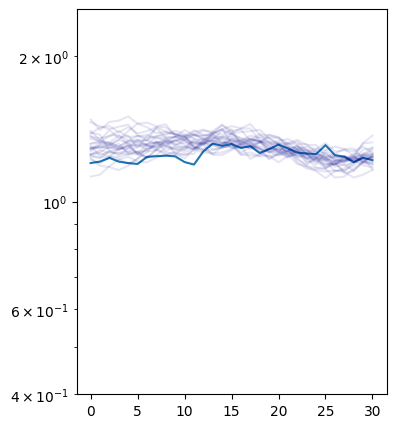

In [12]:
import polars as pl
samps = model1.spread_draws([('Rt', 'time')])

fig, ax = plt.subplots(figsize=[4, 5])

ax.plot(sim_data[0])
samp_ids = np.random.randint(size=25, low=0, high=999)
for samp_id in samp_ids:
    sub_samps = samps.filter(pl.col("draw") == samp_id).sort(pl.col('time'))
    ax.plot(sub_samps.select("time").to_numpy(), 
            sub_samps.select("Rt").to_numpy(), color="darkblue", alpha=0.1)
ax.set_ylim([0.4, 1/.4])
ax.set_yticks([0.5, 1, 2])
ax.set_yscale("log")